In [1]:
import matplotlib.pyplot as plt

from ripper_lut_net import *
from data.mnist import load_mnist_binary

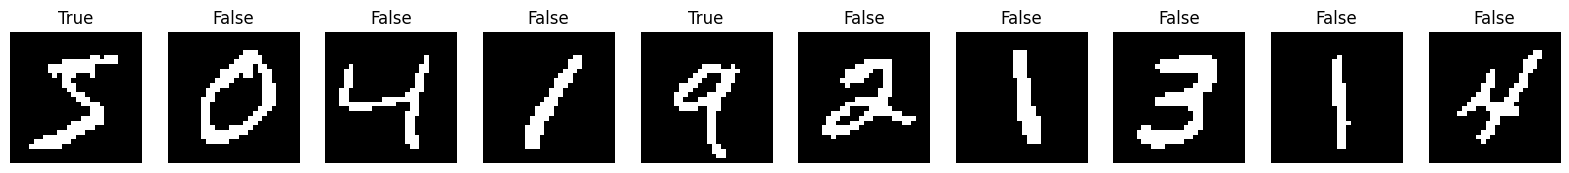

In [2]:
X_train, X_test, y_train, y_test = load_mnist_binary()

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

In [3]:
%%time

##### TRAINING A SIMPLE LUT NETWORK #####

lut_bits = 4
num_layers = 4

lut_net = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[32] * num_layers, verbose=True, mode='lut')
preds_train = lut_net.train(X_train, y_train)
preds_test = lut_net.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Accuracy on training set: 0.76
Accuracy on test set: 0.76
CPU times: user 252 ms, sys: 550 ms, total: 802 ms
Wall time: 5.23 s


In [4]:
# investigate the shape of the .lut_arr_ attribute

for layer in lut_net.lut_arr_:
    print(layer.shape) # (number_of_luts, 2**lut_bits)

(32, 16)
(32, 16)
(32, 16)
(32, 16)
(16,)


In [6]:
# We get the shape (number_of_luts, 2**lut_bits) for each layer. 
# This basically means, that he just stores the output column for each LUT.
# Or more precisely, for each layer we have a list of only the output columns of the LUTs.
# We will have to append the corresponding bit pattern to get a full LUT.

def get_full_lut(out_col, get_dataframe=False):
    num_bits = int(np.log2(len(out_col)))
    in_cols = get_bit_pattern(num_bits)
    full_lut = np.column_stack((in_cols, out_col))
    
    if get_dataframe:
        col_names = [f"bit{i}" for i in range(num_bits)] + ["out"]
        full_lut = pd.DataFrame(full_lut, columns=col_names)
    
    return full_lut

# look at one lut
lut_df = get_full_lut(lut_net.lut_arr_[0][0], get_dataframe=True)
lut_df

,bit0,bit1,bit2,bit3,out
0,False,False,False,False,True
1,False,False,False,True,True
2,False,False,True,False,False
3,False,False,True,True,True
4,False,True,False,False,True
5,False,True,False,True,True
6,False,True,True,False,False
7,False,True,True,True,True
8,True,False,False,False,False
9,True,False,False,True,False


In [7]:
#### Try to perform predictions with ripper

input_bits_df = lut_df.drop('out', axis=1)
output_df = lut_df['out']

ripper_clf = lw.RIPPER()
ripper_clf.fit(input_bits_df, output_df)

ripper_preds = ripper_clf.predict(input_bits_df)

comparison_df = lut_df.copy()
comparison_df['ripper_out'] = ripper_preds
comparison_df.rename(columns={'out': 'lut_out'}, inplace=True)

print(ripper_clf.ruleset_)
comparison_df

[[bit2=False^bit0=False] V [bit3=True^bit0=False]]


,bit0,bit1,bit2,bit3,lut_out,ripper_out
0,False,False,False,False,True,True
1,False,False,False,True,True,True
2,False,False,True,False,False,False
3,False,False,True,True,True,True
4,False,True,False,False,True,True
5,False,True,False,True,True,True
6,False,True,True,False,False,False
7,False,True,True,True,True,True
8,True,False,False,False,False,False
9,True,False,False,True,False,False


In [8]:
#### EXPLORATION 1: Replacing each LUT with the RIPPER results

# This approach cannot possibly result in an improved accuracy. I want to see it nonetheless.

def get_ripper_preds(lut_out_col):
    lut_df = get_full_lut(lut_out_col, get_dataframe=True)
    input_bits_df = lut_df.drop('out', axis=1)
    output_df = lut_df['out']

    ripper_clf = lw.RIPPER()
    ripper_clf.fit(input_bits_df, output_df)

    ripper_preds = ripper_clf.predict(input_bits_df)
    
    del ripper_clf
    
    # ensuring that the output has the same shape and type as the input
    return ripper_preds

In [9]:
lut_net_ripper = RipperLut(bits=[lut_bits] * (num_layers + 1), hidden_layers=[32] * num_layers, verbose=True, mode='lut')
preds_train = lut_net_ripper.train(X_train, y_train)
preds_test = lut_net_ripper.predict(X_test)
print(f"Accuracy on training set: {accuracy_score(preds_train, y_train):.2f}")
print(f"Accuracy on test set: {accuracy_score(preds_test, y_test):.2f}")

100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Accuracy on training set: 0.76
Accuracy on test set: 0.76


In [10]:
# replace all the output columns of the LUTs with the RIPPER predictions

for i, layer in enumerate(lut_net_ripper.lut_arr_):
    # since the last layer is of dim (16,) not (32, 16), we have to make sure it has the right shape
    if i == num_layers:
        layer = [layer]
    
    for j, lut_out_col in enumerate(layer):
        ripper_preds = get_ripper_preds(lut_out_col)
        
        if len(ripper_preds) == 1:
            ripper_preds = ripper_preds[0]
            
        lut_net_ripper.lut_arr_[i][j] = ripper_preds

In [11]:
# calculate accuracy again
preds_lut_net_ripper = lut_net_ripper.predict(X_test)
print(f"Accuracy on test set with RIPPER substitution: {accuracy_score(preds_lut_net_ripper, y_test):.2f}")

Accuracy on test set with RIPPER substitution: 0.52


In [12]:
# check the shapes of the LUTs again
for layer in lut_net_ripper.lut_arr_:
    print(layer.shape)

(32, 16)
(32, 16)
(32, 16)
(32, 16)
(16,)


#### Some hindsight discussion

**Why did I expect this to work?**
> My idea was, that RIPPER would be capable of learning the exact same output column. I thought that RIPPER would find a subset of relevant columns and we could prune the back connections of the remaining ones.

**Why did it not work?**
> Of course RIPPER will not learn the same output. It needs to be trained on the dataset not a logic table.

**Takeaways**
> Although RIPPER is not suited for this usecase, the basic idea of finding the relevant columns and pruning the rest could be archieved with another algorithm. However, it is only useful for pruning. Since the output columns would remain the same, the accuracy would not improve.


In [ ]:
#### EXPERIMENT 2: RIPPER as drop in replacement for get_lut
# The relevant code can be found in the file ripper_lut_net.py
# REMARK: The code of this experiment is also based on the new ripper_lut_net.py but simply executed in 'lut' mode.